In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *

In [3]:
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/ua_6hrPlevPt_MPI-ESM1-2-HR_historical_r8i1p1f1_gn_185001010600-185501010000.nc')

In [5]:
ds.drop('test')

ValueError: One or more of the specified variables cannot be found in this dataset

In [35]:
cmip_dir = '/data/stephan/WeatherBench//CMIP/5.625deg/'
era_dir = '/data/stephan/WeatherBench//5.625deg/'

## Compare fields

In [61]:
var = 'u_component_of_wind'
cmip = xr.open_mfdataset(f'{cmip_dir}/{var}/*.nc')
era = xr.open_mfdataset(f'{era_dir}/{var}/*.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,
/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In xarray version 0.15 the 

In [63]:
cmip

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, plev: 3, time: 241060)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * plev     (plev) float64 8.5e+04 5e+04 2.5e+04
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1850-01-01 ... 2014-12-31T18:00:00
Data variables:
    u        (time, plev, lat, lon) float32 dask.array<chunksize=(1460, 3, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time:            0.0
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    creation_date:          2019-09-25T21:27:10Z
    data_specs_version:     01.00.31
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              6hrPt
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.EC-Earth-Con...
    grid:                   T255L91
    grid_label:             gr
    initialization_index:   1
    institution:            AEMET, Spain; BSC, Spain; CNR-ISAC, Italy; DMI, D...
    institution_id:         EC-Earth-Consortium
    mip_era:                CMIP6
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       EC-Earth3
    parent_time_units:      days since 1850-01-01
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos
    source:                 EC-Earth3 (2019): \naerosol: none\natmos: IFS cy3...
    source_id:              EC-Earth3
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               6hrPlevPt
    table_info:             Creation Date:(24 July 2019) MD5:70649eeb16bc90c4...
    title:                  EC-Earth3 output prepared for CMIP6
    variable_id:            ua
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/d55d869d-f5a1-4e44-ab73-ccbd7565a73e
    history:                2019-09-25T21:09:09Z ; CMOR rewrote data to be co...

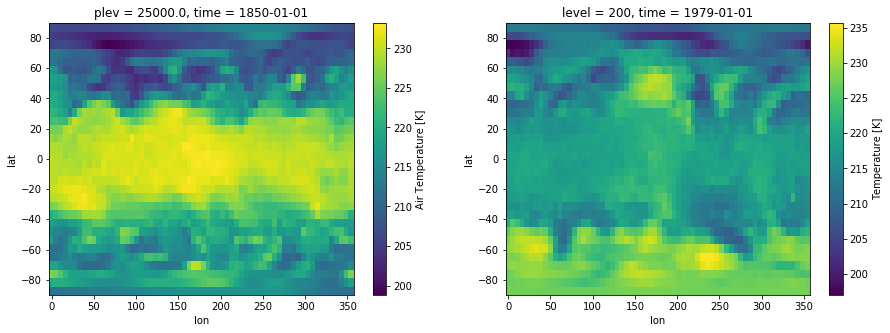

In [39]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmip.t.isel(time=0).sel(plev=2.5e4).plot(ax=ax1)
era.t.isel(time=0).sel(level=200).plot(ax=ax2)

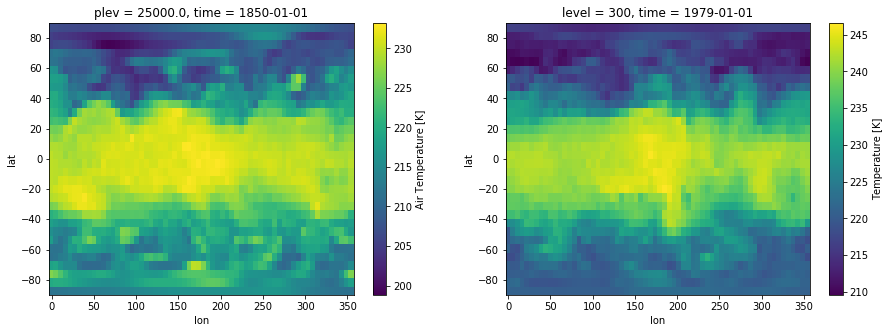

In [40]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmip.t.isel(time=0).sel(plev=2.5e4).plot(ax=ax1)
era.t.isel(time=0).sel(level=300).plot(ax=ax2)

In [45]:
cmip.t

<xarray.DataArray 't' (time: 241060, plev: 10, lat: 32, lon: 64)>
dask.array<concatenate, shape=(241060, 10, 32, 64), dtype=float32, chunksize=(1464, 10, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * plev     (plev) float64 1e+03 5e+03 1e+04 2.5e+04 ... 8.5e+04 9.25e+04 1e+05
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1850-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  air_temperature
    long_name:      Air Temperature
    comment:        Air Temperature
    units:          K
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-09-25T21:16:40Z altered by CMOR: Reordered dimension...

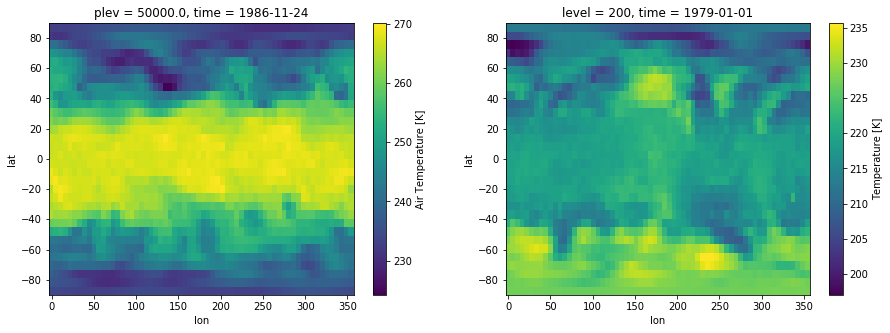

In [60]:
fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
cmip.t.isel(time=200000, plev=4).plot(ax=ax1)
era.t.isel(time=0).sel(level=200).plot(ax=ax2)

## Compare dataloader

In [106]:
exp_id = '13-resnet_bn_dr_0.1'
datadir = '/data/stephan/WeatherBench/2.8125deg/'
# datadir = '/data/stephan/WeatherBench/5.625deg/'
model_save_dir = '/home/rasp/data/myWeatherBench/predictions/saved_models/'
pred_save_dir = '/home/rasp/data/myWeatherBench/predictions/'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = False
dropout = 0.1

batch_size = 32
nt_in = 1
l2 = 0
skip = True

In [107]:
tmp_dict = var_dict.copy()

In [108]:
tmp_dict.pop('constants')

['lsm', 'orography', 'lat2d']

In [104]:
var_dict

{'geopotential': ('z', [200, 500, 850]),
 'temperature': ('t', [200, 500, 850]),
 'u_component_of_wind': ('u', [200, 500, 850]),
 'v_component_of_wind': ('v', [200, 500, 850]),
 'constants': ['lsm', 'orography', 'lat2d']}

### A. Standard

In [79]:
datadir = era_dir

In [80]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [81]:
ds_train = ds.sel(time=slice('2010', '2014'))

In [82]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, load=False, shuffle=False
)

DG start 23:32:43.195508
DG normalize 23:32:43.244948
DG load 23:33:18.657161
DG done 23:33:18.657249


### B. CMIP

In [145]:
datadir = cmip_dir

In [146]:
var_dict = {'geopotential': ('z', [250, 500, 850]), 'temperature': ('t', [250, 500, 850]), 'u_component_of_wind': ('u', [250, 500, 850]), 'v_component_of_wind': ('v', [250, 500, 850])}

In [147]:
ds_cmip = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc') for var in var_dict.keys()])

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


KeyboardInterrupt: 

In [ ]:
ds_cmpi

In [86]:
ds_train = ds_cmip.sel(time=slice('2000', '2014'))

In [87]:
ds_train['plev'] /= 100

In [88]:
ds_train = ds_train.rename({'plev': 'level'})

In [89]:
dg_train_cmip = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, load=False, shuffle=False
)

DG start 23:35:51.632160
DG normalize 23:35:51.657199
DG load 23:35:58.153247
DG done 23:35:58.153332


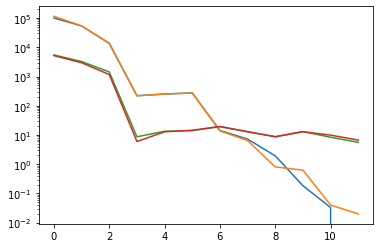

In [90]:
plt.plot(dg_train_cmip.mean)
plt.plot(dg_train.mean[:12])
plt.plot(dg_train_cmip.std)
plt.plot(dg_train.std[:12])
plt.yscale('log')

In [132]:
X, y = dg_train[100]

In [133]:
Xc, yc = dg_train_cmip[100]

In [134]:
X.shape

(32, 32, 64, 15)

In [142]:
dg_train.dt

2.0

In [143]:
dg_train_cmip.dt

12.0

In [135]:
dg_train.data.level_names

<xarray.DataArray 'level_names' (level: 15)>
array(['z_200', 'z_500', 'z_850', 't_200', 't_500', 't_850', 'u_200',
       'u_500', 'u_850', 'v_200', 'v_500', 'v_850', 'lsm', 'orography',
       'lat2d'], dtype='<U9')
Coordinates:
  * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
    level_names  (level) <U9 'z_200' 'z_500' 'z_850' ... 'orography' 'lat2d'

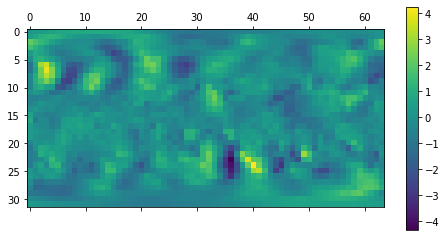

In [138]:
plt.matshow(X[-1, :, :, 9])
plt.colorbar()

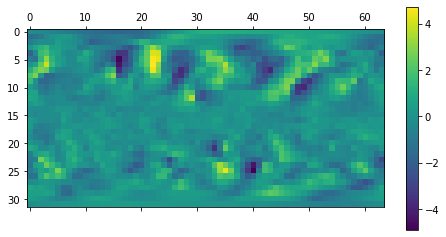

In [139]:
plt.matshow(Xc[-1, :, :, 9])
plt.colorbar()

## Eval 42

In [3]:
from src.score import *

In [4]:
preds = xr.load_dataset('/home/rasp/data/myWeatherBench/predictions//42-resnet_cmip.nc')

In [5]:
test_years = ['2008', '2014']

In [6]:
valdir = '/data/stephan/WeatherBench/CMIP/5.625deg/'

In [9]:
z500_valid = load_test_data(
    f'{valdir}geopotential', 'z', years=slice(test_years[0], test_years[1]), cmip=True)
t850_valid = load_test_data(
    f'{valdir}temperature', 't', years=slice(test_years[0], test_years[1]), cmip=True)

In [10]:
z500_valid

<xarray.DataArray 'z' (time: 10228, lat: 32, lon: 64)>
dask.array<getitem, shape=(10228, 32, 64), dtype=float32, chunksize=(1464, 32, 64), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2008-01-01 ... 2014-12-31T18:00:00
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    comment:        Geopotential is the sum of the specific gravitational pot...
    units:          m
    cell_methods:   area: mean time: point
    cell_measures:  area: areacella
    history:        2019-09-25T21:32:35Z altered by CMOR: Reordered dimension...

In [11]:
print(compute_weighted_rmse(preds.z, z500_valid).load())

<xarray.DataArray 'z_rmse' ()>
array(425.46596647)


In [12]:
print(compute_weighted_rmse(preds.t, t850_valid).load())

<xarray.DataArray 't_rmse' ()>
array(2.31148176)


In [15]:
import os
from src.networks import *
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [17]:
model = keras.models.load_model('/home/rasp/data/myWeatherBench/predictions/saved_models//42-resnet_cmip.h5',
                               custom_objects={'PeriodicConv2D': PeriodicConv2D})

In [18]:
exp_id = '13-resnet_bn_dr_0.1'
datadir = '/data/stephan/WeatherBench/5.625deg/'
model_save_dir = '/home/rasp/data/myWeatherBench/predictions/saved_models/'
pred_save_dir = '/home/rasp/data/myWeatherBench/predictions/'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 'constants': ['lsm','orography','lat2d']}
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
dropout = 0.1

batch_size = 64
nt_in = 1
l2 = 0
skip = True

In [19]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [20]:
ds_train = ds.sel(time=slice('1979', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [21]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample, load=False
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 00:15:31.588073
DG normalize 00:15:31.617780
DG load 00:15:46.397045
DG done 00:15:46.397249
DG start 00:15:46.397861
DG normalize 00:15:46.420829
DG load 00:15:46.427766
Loading data into RAM
DG done 00:15:53.423492


In [22]:
from src.data_generator import *

In [23]:
preds = create_predictions(model, dg_test)

In [24]:
valdir = datadir

In [25]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z')
t850_valid = load_test_data(f'{valdir}temperature_850', 't')

In [26]:
compute_weighted_rmse(preds.z, z500_valid).load()

<xarray.DataArray 'z_rmse' ()>
array(530.31670597)
Coordinates:
    level    int32 500

In [28]:
compute_weighted_rmse(preds.t, t850_valid).load()

<xarray.DataArray 't_rmse' ()>
array(2.54800582)
Coordinates:
    level    int32 850

## Take stock

In [3]:
ecdir = '/data/stephan/WeatherBench/CMIP/EC-Earth/5.625deg/'

In [6]:
ecz = xr.open_mfdataset(f'{ecdir}geopotential/*.nc', combine='by_coords')
ect = xr.open_mfdataset(f'{ecdir}temperature/*.nc', combine='by_coords')
ecu = xr.open_mfdataset(f'{ecdir}u_component_of_wind/*.nc', combine='by_coords')
ecv = xr.open_mfdataset(f'{ecdir}v_component_of_wind/*.nc', combine='by_coords')

In [10]:
ecz.plev.values, ect.plev.values, ecu.plev.values, ecv.plev.values

(array([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,
         82500.,  80000.,  77500.,  75000.,  70000.,  65000.,  60000.,
         55000.,  50000.,  45000.,  40000.,  35000.,  30000.,  25000.,
         22500.,  20000.,  17500.,  15000.,  12500.,  10000.]),
 array([  1000.,   5000.,  10000.,  25000.,  50000.,  60000.,  70000.,
         85000.,  92500., 100000.]),
 array([85000., 50000., 25000.]),
 array([85000., 50000., 25000.]))

In [15]:
mpidir = '/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/'

In [16]:
mpiz = xr.open_mfdataset(f'{mpidir}geopotential/*.nc', combine='by_coords')
mpit = xr.open_mfdataset(f'{mpidir}temperature/*.nc', combine='by_coords')
# mpiu = xr.open_mfdataset(f'{mpidir}u_component_of_wind/*.nc', combine='by_coords')
# mpiv = xr.open_mfdataset(f'{mpidir}v_component_of_wind/*.nc', combine='by_coords')

In [17]:
mpiz.plev.values, mpit.plev.values, #mpiu.plev.values, mpiv.plev.values

(array([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,
         82500.,  80000.,  77500.,  75000.,  70000.,  65000.,  60000.,
         55000.,  50000.,  45000.,  40000.,  35000.,  30000.,  25000.,
         22500.,  20000.,  17500.,  15000.,  12500.,  10000.,   5000.]),
 array([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,
         82500.,  80000.,  77500.,  75000.,  70000.,  65000.,  60000.,
         55000.,  50000.,  45000.,  40000.,  35000.,  30000.,  25000.,
         22500.,  20000.,  17500.,  15000.,  12500.,  10000.,   5000.]))

In [ ]:
mpiz

In [19]:
[f'{y}01010600-{y+5}01010000' for y in range(1850, 2015)]

['185001010600-185501010000',
 '185101010600-185601010000',
 '185201010600-185701010000',
 '185301010600-185801010000',
 '185401010600-185901010000',
 '185501010600-186001010000',
 '185601010600-186101010000',
 '185701010600-186201010000',
 '185801010600-186301010000',
 '185901010600-186401010000',
 '186001010600-186501010000',
 '186101010600-186601010000',
 '186201010600-186701010000',
 '186301010600-186801010000',
 '186401010600-186901010000',
 '186501010600-187001010000',
 '186601010600-187101010000',
 '186701010600-187201010000',
 '186801010600-187301010000',
 '186901010600-187401010000',
 '187001010600-187501010000',
 '187101010600-187601010000',
 '187201010600-187701010000',
 '187301010600-187801010000',
 '187401010600-187901010000',
 '187501010600-188001010000',
 '187601010600-188101010000',
 '187701010600-188201010000',
 '187801010600-188301010000',
 '187901010600-188401010000',
 '188001010600-188501010000',
 '188101010600-188601010000',
 '188201010600-188701010000',
 '18830101